# Enhance the shadow of a grayscale image

In this notebook different examples are given to enhance a shadow within an image. The methods here use a grayscale image, and put emphasis on the spatial neighborhood. While other methods are used to transform different bands to a single image, as these are based on the spectral signature.

### import of funcitons from libraries
First we need to import some generic libraries for plotting and file management

In [1]:
import matplotlib.pyplot as plt

import os
import numpy as np

Than more specific functions can be imported from the **dhdt** library

In [2]:
Than more specific functions can be imported from the **dhdt** libraryfrom dhdt.generic.mapping_io import read_geo_image
from dhdt.generic.handler_sentinel2 import get_s2_image_locations, get_s2_dict

from dhdt.input.read_sentinel2 import list_central_wavelength_msi, read_stack_s2, s2_dn2toa, read_mean_sun_angles_s2

from dhdt.preprocessing.shadow_transforms import apply_shadow_transform
from dhdt.preprocessing.shadow_filters import enhance_shadows
from dhdt.preprocessing.image_transforms import mat_to_gray, inverse_tangent_transformation

from dhdt.postprocessing.solar_tools import make_shading, make_shadowing

### data preparation
Here some local data is taken, please adjust this to your own liking. A link to a Sentinel-2 directory is given, as well as, a link to a CopDEM elevation model of the same resolution.

In [3]:
dat_dir = '/local/path/S2A_MSIL1C_20201019T213531_N0209_R086_T05VMG_20201019T220042.SAFE' 

Z_file = "COP-DEM-05VMG.tif"
Z_dir = os.path.join('/local/path','Cop-DEM_GLO-30')

Z = read_geo_image(os.path.join(Z_dir, Z_file))[0]

A selection of bands is used here (only the 10m), and a random subset of the image is taken, so the details can be seen. Furthermore, most meta-data is extracted and put in a dataframe and a dictionary.

In [4]:
boi = ['red', 'green', 'blue', 'nir']
h,w = 100, 500
s2_df = list_central_wavelength_msi()
s2_df = s2_df[s2_df['common_name'].isin(boi)]
s2_df, datastrip_id = get_s2_image_locations(os.path.join(dat_dir, 'MTD_MSIL1C.xml'), s2_df)
s2_dict = get_s2_dict(s2_df)

Now the data can be loaded and cut to the subset.

In [5]:
im_stack, spatialRef, geoTransform, targetprj = read_stack_s2(s2_df)
im_stack = mat_to_gray(im_stack)
m,n = im_stack.shape[0], im_stack.shape[1]
j_min, i_min = np.random.randint(w, n-w), np.random.randint(h, m-h)
j_max, i_max = j_min + w, i_min + h
im_stack = im_stack[i_min:i_max,j_min:j_max,:]

For convenience, the data can be plotted. Here the near infrared band is shown.

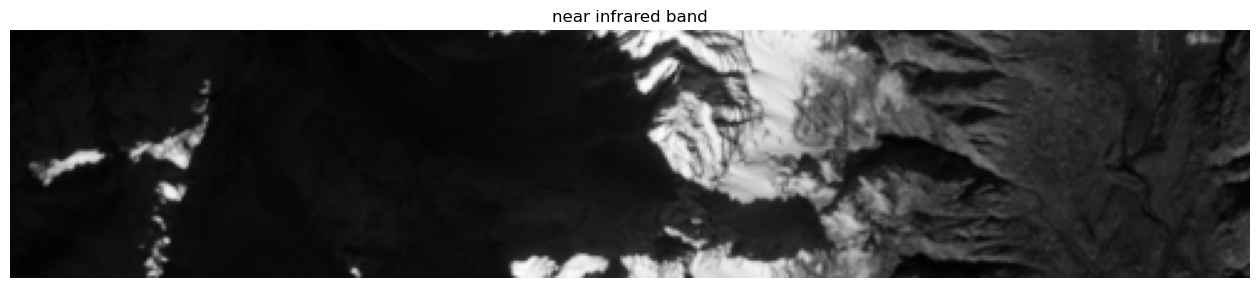

In [6]:
plt.rcParams['figure.figsize'] = [16.,4.]
plt.title('near infrared band'), 
plt.imshow(inverse_tangent_transformation(4*im_stack[:,:,-1]), cmap=plt.cm.gray), plt.axis('off');

Since an elevation model is also loaded, a synthetic image can also be created. Which will hopefully ease the interpretation of the different methodologies later on.

In [8]:
sun_zn, sun_az = read_mean_sun_angles_s2(s2_dict['MTD_TL_path'])
Shw =  make_shadowing(Z.data, sun_az, sun_zn)
Shd =  make_shading(Z.data, sun_az, sun_zn)
Shw, Shd = Shw[i_min:i_max,j_min:j_max], Shd[i_min:i_max,j_min:j_max]

A visualization of a shading and a shadowing can now be created

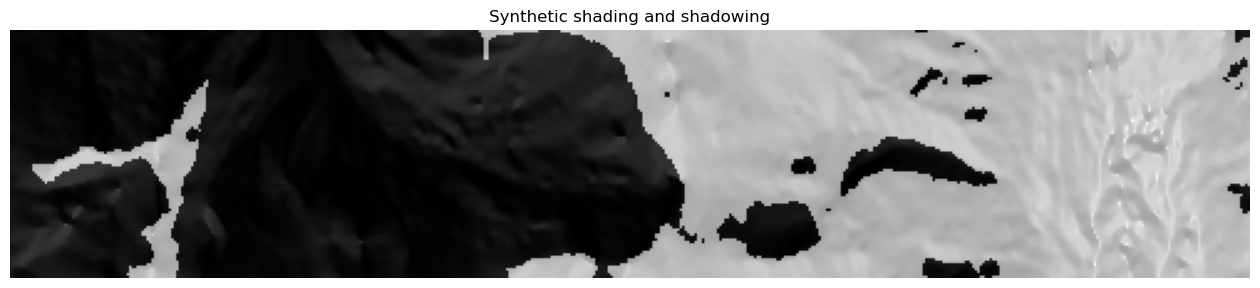

In [9]:
plt.rcParams['figure.figsize'] = [16.,4.]
plt.title('Synthetic shading and shadowing'),
plt.imshow(0.5*Shd+(1-Shw), cmap=plt.cm.gray), plt.axis('off');

Now the multi-spectral dataset is transformed to a shadow image, via pixel-wise spectral transformation

In [11]:
i_bl = np.flatnonzero(s2_df['common_name']=='blue')[0]
i_gr = np.flatnonzero(s2_df['common_name'] == 'green')[0]
i_rd = np.flatnonzero(s2_df['common_name']=='red')[0]
i_nr = np.flatnonzero(s2_df['common_name'] == 'nir')[0]
S = apply_shadow_transform('entropy',im_stack[...,i_bl], im_stack[...,i_gr],im_stack[...,i_rd],[],
                           im_stack[...,i_nr], [], a=138.)[0]
S = inverse_tangent_transformation(S)

The shadow image can be plotted, which forms the input for the different shadow enhancement techniques.

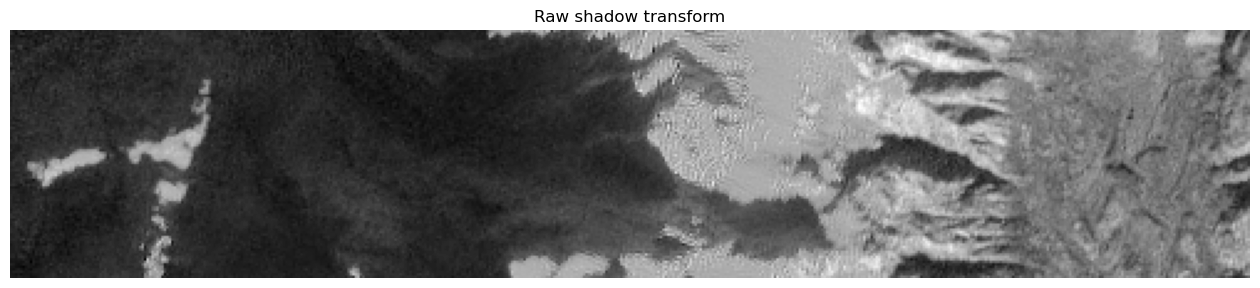

In [12]:
plt.rcParams['figure.figsize'] = [16.,4.]
plt.title('Raw shadow transform'), plt.imshow(S, cmap=plt.cm.gray), plt.axis('off');

### main processing
In the following, the different spatial shadow enhancement techniques are calculated and shown.

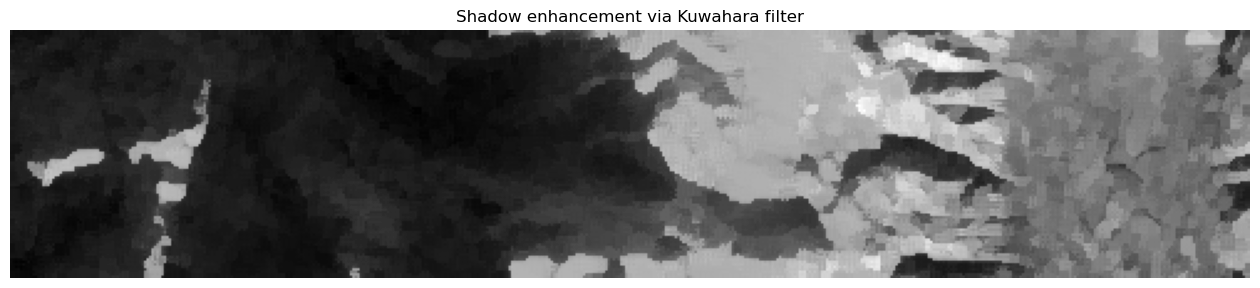

In [13]:
S_k = enhance_shadows(S, 'kuwahara')
plt.rcParams['figure.figsize'] = [16.,4.]
plt.title('Shadow enhancement via Kuwahara filter'), plt.imshow(S_k, cmap=plt.cm.gray), plt.axis('off');

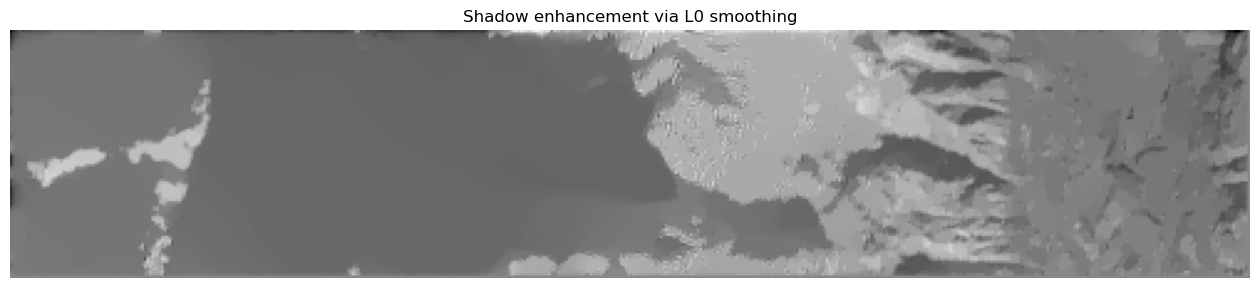

In [14]:
S_l = enhance_shadows(S, 'L0', lamb=1E-3)
plt.rcParams['figure.figsize'] = [16.,4.]
plt.title('Shadow enhancement via L0 smoothing'), plt.imshow(S_l, cmap=plt.cm.gray), plt.axis('off');

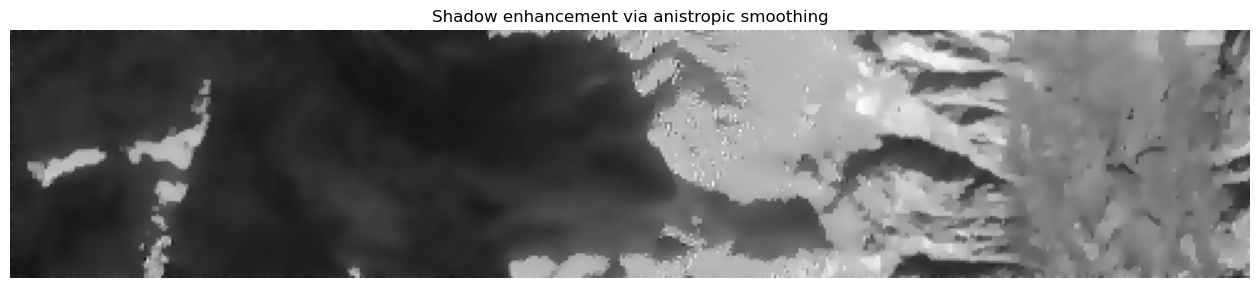

In [15]:
S_a = enhance_shadows(S, 'anistropic', K=.03, n=8)
plt.rcParams['figure.figsize'] = [16.,4.]
plt.title('Shadow enhancement via anistropic smoothing'), plt.imshow(S_a, cmap=plt.cm.gray), plt.axis('off');

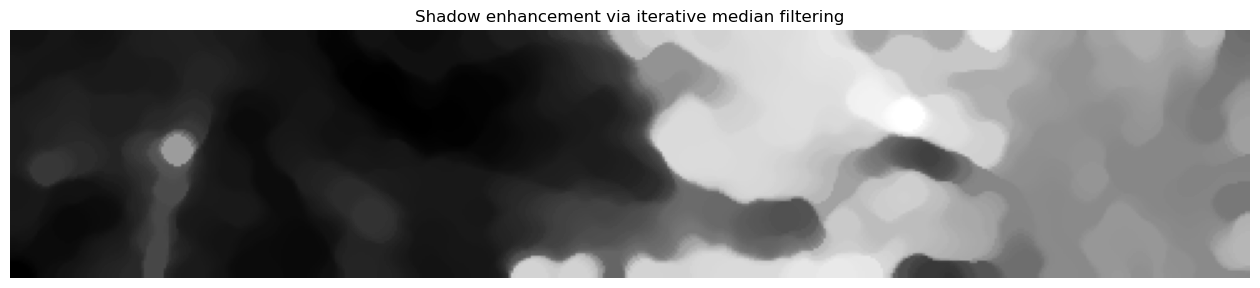

In [16]:
S_m = enhance_shadows(S, 'median')
plt.rcParams['figure.figsize'] = [16.,4.]
plt.title('Shadow enhancement via iterative median filtering'), plt.imshow(S_m, cmap=plt.cm.gray), plt.axis('off');